# `ggbunch()` : Combining Plots with Custom Layout

`ggbunch()` provides a flexible way to combine multiple plots into a single figure.   
Unlike grid-based layouts, it allows precise positioning and sizing of each plot using relative coordinates.   
You can place plots anywhere within the container, adjust their sizes individually,
and fine-tune their positions with pixel-level offsets.

The geodata is provided by © OpenStreetMap contributors and is made available here under the Open Database License (ODbL).



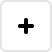
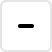
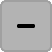
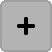
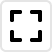
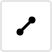
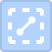
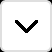
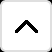
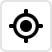
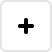
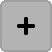
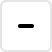
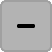
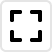
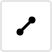
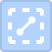
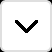
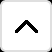
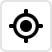

In [1]:
import pandas as pd
import geopandas as gpd

from lets_plot import *
from lets_plot.geo_data import *          # Geo-coding

LetsPlot.setup_html()


In [2]:
df_volc = pd.read_csv("https://raw.githubusercontent.com/JetBrains/lets-plot/refs/heads/master/docs/f-25a/data/volcano_indo.csv", encoding ='utf-8')
df_volc.head(3)


,Unnamed: 0,Name,Shape,Elevation,Last_Eruption,Geo_Location,Island
0,0,Weh,stratovolcano,"617 metres (2,024 ft)",Pleistocene,﻿5.82°N 95.28°E﻿,Sumatra
1,1,Seulawah Agam,stratovolcano,"1,810 metres (5,940 ft)",1839 (2),﻿5.448°N 95.658°E﻿,Sumatra
2,2,Peuet Sague,complex volcano,"2,801 metres (9,190 ft)",25 December 2000 (2),﻿4.914°N 96.329°E﻿,Sumatra


In [3]:
def dms_to_decimal(dms_string):
    """
    Convert DMS coordinates to decimal degrees.
    
    >>> dms_to_decimal("99.539°E")
    99.539
    
    >>> dms_to_decimal("99.539°W")
    -99.539
    
    """
    degrees, direction = dms_string.split('°')
    degrees = float(degrees)
    
    # Adjusting the sign based on direction
    if direction in ['S', 'W']:
        degrees *= -1
    
    return degrees

In [4]:
df_volc = df_volc.dropna(subset=['Geo_Location'])

# Split 'Geo_Location' str.
lat_lon_dms = df_volc.Geo_Location.str.split(' ').apply(lambda lst: lst[1:3])

# Remove BOM symbols (\ufeff) and
# convert DMS strings to decimal degrees.
lat_lon_dd = lat_lon_dms.apply(lambda lst: [dms_to_decimal(v.replace('\ufeff', '')) for v in lst])

# Create a Geodataframe by adding the 'geometry' column.
latitudes = lat_lon_dd.apply(lambda pair: pair[0])
longitudes = lat_lon_dd.apply(lambda pair: pair[1])

gdf_volc = gpd.GeoDataFrame(df_volc, geometry=gpd.points_from_xy(longitudes, latitudes))
gdf_volc.head(3)

,Unnamed: 0,Name,Shape,Elevation,Last_Eruption,Geo_Location,Island,geometry
0,0,Weh,stratovolcano,"617 metres (2,024 ft)",Pleistocene,﻿5.82°N 95.28°E﻿,Sumatra,POINT (95.28000 5.82000)
1,1,Seulawah Agam,stratovolcano,"1,810 metres (5,940 ft)",1839 (2),﻿5.448°N 95.658°E﻿,Sumatra,POINT (95.65800 5.44800)
2,2,Peuet Sague,complex volcano,"2,801 metres (9,190 ft)",25 December 2000 (2),﻿4.914°N 96.329°E﻿,Sumatra,POINT (96.32900 4.91400)


In [5]:
# Map of Indonesia
indonesia_gcoder = geocode_countries('Indonesia')

indonesia_map = (ggplot() 
  + geom_map(map=indonesia_gcoder, size=0.5) 
  # The Equator
  + geom_hline(yintercept=0, linetype="dotted", tooltips='none')
  # Volcanoes
  + geom_point(data=gdf_volc, color='#fddbc7', tooltips=layer_tooltips()
               .title("@Name") 
               .line("Last Eruption | @Last_Eruption"))
  + theme_void() + theme(plot_inset=0)
)

indonesia_map + ggsize(800, 304)


In [6]:
# Map of Southeast Asia
southeast_asia_gcoder = geocode_countries(['Indonesia', 
                                   'Australia', 'Malaysia', 'Thailand', 'Taiwan', 'Vietnam', 
                                   'Philippines', 'Papua New Guinea', 'Palau',
                                   'Myanmar', 'Laos', 'Cambodia',
                                   'Indonesia', 'India', 'Bangladesh', 'China',
                                   'Bhutan', 'Nepal', 'Sri Lanka',
                                   'South Korea', 'North Korea', 'Japan'
                                  ])

southeast_asia_map = (ggplot() 
  + geom_map(map=southeast_asia_gcoder, fill='paper', size=0.1) 
  # The Equator
  + geom_hline(yintercept=0, linetype="dotted", tooltips='none')
  # Indonesia bounding box                    
  + geom_rect(map=indonesia_gcoder, size=0.2, fill='paper', alpha=0.3, color='red')
  + theme_grey() + theme(axis='blank', panel_grid='blank')
  + theme(plot_background=element_rect(size=1), plot_inset=0)
)

southeast_asia_map

#### Combine Two Maps in One Figure Using `ggbunch()`

In [7]:
(ggbunch(
    plots=[indonesia_map, southeast_asia_map],
    regions=[(0, 0, 1, 1),                     # <- Indonesia map takes 100% of available space 
             (0.85, 0, 0.15, 0.53,             # <- Southeast Asia inset map
              -10, 0)                          # <- Offset in px for precise positioning
    ]
)
  + theme(plot_background=element_rect(size=1), plot_inset=0,
          plot_title=element_text(family='bold', size=20, hjust=0.5, color='#1a1a1a'))
  + ggtitle('Indonesia Volcanic Activity')
  + ggsize(800, 325)
)